# Bezier Loss Function

This notebook demonstrates the Bezier Loss Function which is regression loss function. Unlike traditional neural networks where the interpretation of the network output are directly points in the output space for direct use, the neural network outputs are points in the output to construct Bezier Curves over some predifined parameter interval.

## Bezier Curves

[Bezier Curves](https://en.wikipedia.org/wiki/B%C3%A9zier_curve) are polynomial curves of degree $d$ constructed from linear interpolations between successive points in a list of points.

$$p(t) = \sum_{k=0}^d {d \choose k} (1-t)^{d-k} t^k P_k$$

Note that the points $P$'s all exist in some arbitrary dimensional space but the parameter $t$ is real and $t\in[0,\ 1]$. Bezier curves also have usefull properties such as easy calculations of $\dot{p}$, embedding lower degree polynomials in higher degree Bezier Curves, and the ability enforce levels of continuity.

## Theoretical difference from standard sequential neural networks.

Normally training of neural networks have the network output try and approximate the function $f:\mathit{X}\mapsto\mathit{Y}$ based on a finite number of samples of the mapping. In this way, the network is $\hat{f}:\mathit{X}\mapsto\hat{\mathit{Y}}$ with $space(\hat{\mathit{Y}}) \equiv space(\mathit{Y})$ (e.g. $\mathbf{R}^{n}$) where the network is trained by minimizing a loss function $\ell:\mathit{Y}\times\hat{\mathit{Y}}\mapsto \mathbf{R}^+$. However as neural networks are being treated as constructors of the Bezier curve, then each training sample need $m$ curve samples of $f$ around the desired interval with given values of $t$ for each curve sample. This means the network desired output for training in tensorflow is $\mathbf{N}\times\mathbf{R}\times space(\mathit{Y})$ and the network predicted outputs are $\mathbf{N}^d\times space(\mathit{Y})$ where $\mathbf{N}^d$ is $\lbrace 0,\ 1,\cdots,\ d\rbrace$. However, since the neural network output is interpret as a Bezier curve, there is another mapping $B: \mathbf{N}^d \times space(\mathit{Y})\mapsto \mathbf{P}^d_{space(\mathit{Y})}$ where $\mathbf{P}^d_{space(\mathit{Y})}$ is the set of all polynomial curves of degree $d$ in $space(\mathit{Y})$. With a convolution $B\circ\hat{f}: \mathit{X}\mapsto \mathbf{P}^d_{space(\mathit{Y})}$, the bezier loss function is defined as $\ell_B:(\mathbf{R}\times space(\mathit{Y}))\times \mathbf{P}^d_{space(\mathit{Y})}\mapsto\mathbf{R}^+$.

## Tensorflow implementation

The spaces are handled as three dimensional tensors in tensorflow with the following ordering:

1. Sample index
2. Point index
3. Dimension index

For both true and network outputs, the sample index are aligned. The point index for the true outputs is an unordered array of $m$ points and $t$ parameter values while the network outputs is an ordered array of $d+1$ points to form the Bezier curve. The dimension index for the true outputs has the first element be $t$ parameter value of the point for matching the Bezier Curve and the rest being the vector in the desired output space. The network output dimension index is only the vector in the desired output space.

## Demo

Load in the appropriate libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.special import comb
import sys
import tensorflow as tf
import time

t1 = time.time()

# Import custom loss function
sys.path.append(os.path.abspath('../functions'))
from custom_loss_functions import bezier_loss

t2 = time.time()

print("Time to import smoothness loss function is %f [s]" % (t2 - t1))

Time to import smoothness loss function is 1.546355 [s]


Create the fictional input and output matrices. Input matrix is simply the coefficients of the polynomial and the output matrix is a list of outputs of the polynomial over a list of $t$ values.

In [2]:
def f(x, coeff):
    """Output of a polynomial p(x) given a list of coefficients of highest ($d$) to lowest ($0$)"""
    ans = 0.
    lcoeff = list(coeff)
    lcoeff.reverse()
    for d, c in enumerate(lcoeff):
        ans += c*(x ** d)
    return ans

# Creating input matrix
degree = 3  # degree of desired polynomial
X = np.random.rand(1, degree + 1)  # random coefficients in [0, 1)

fvec = np.vectorize(lambda x: f(x, X[0, :]))

# Creating output matrix
tvec = np.linspace(0, 1, 11)
Y = fvec(tvec).reshape((1,) + tvec.shape + (1,))
Y = np.concatenate((tvec.reshape((1,) + tvec.shape + (1,)), Y), axis=2)
print(Y)

[[[0.         0.3437618 ]
  [0.1        0.403438  ]
  [0.2        0.48384593]
  [0.3        0.58886416]
  [0.4        0.72237125]
  [0.5        0.88824576]
  [0.6        1.09036626]
  [0.7        1.33261132]
  [0.8        1.61885949]
  [0.9        1.95298935]
  [1.         2.33887945]]]


Create the tensorflow model.

In [3]:
# Model constants
n_layers = 10
degree = 5  # degree of Bezier curve
dp1 = degree + 1  # degree plus 1 i.e. number of points needed
network_width = max(X.shape[1], dp1)

# Build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(network_width, activation=tf.nn.leaky_relu, input_shape=(X.shape[1],)))
for _ in range(1, n_layers - 1):
    model.add(tf.keras.layers.Dense(network_width, activation=tf.nn.leaky_relu))
model.add(tf.keras.layers.Reshape((dp1, 1), input_shape=(network_width,)))

# Compile and show model characteristics
model.compile(
    optimizer='adam',
    # loss=loss_function,
    loss=bezier_loss,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 30        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 4

Initial network output with calculated loss function.

In [4]:
def bezier_output(t, points):
    """Returns Bezier curve value at t given points"""
    d = len(points) - 1
    ans = np.zeros(points.shape[1:])
    
    for i, p in enumerate(points):
        ans += comb(d, i)*(t**i)*((1-t)**(d-i))*p
    
    return ans

In [5]:
Ypred = model.predict(X)
loss_value = model.evaluate(X, Y)

points = Ypred[0, :, 0]
sse = 0.
for i, t in enumerate(tvec):
    sse += (bezier_output(t, points) - Y[0, i, 1]) ** 2
    
print("Tensorflow loss value: %f" % loss_value)
print("Calculated loss value: %f" % sse)

1/1 [==============================] - 0s 441ms/sample - loss: 17.0007
Tensorflow loss value: 17.000650
Calculated loss value: 17.000652


Epoch training.

C:\Users\Patrick\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


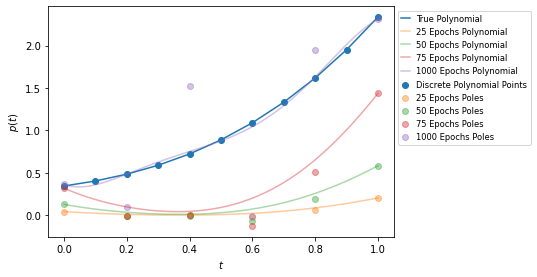

In [6]:
total_epochs = 1000
epochs_to_go = total_epochs
epochs_per_group = 25
n_epochs = 3

# Loss history
loss_h = np.array([loss_value])

# Setting up plots
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0.1, 0.125, 0.6, 0.8])

# Plotting parts
xplotting = np.linspace(0, 1, degree + 1)
tplotting = np.linspace(0, 1, 101)

ax.scatter(Y[0, :, 0], Y[0, :, 1], label='Discrete Polynomial Points')
ax.plot(tvec, fvec(tvec), label='True Polynomial')

# Epoch Training
for i in range(n_epochs):
    epoch_label = "%i Epochs" % ((i+1)*epochs_per_group)
    
    # Train for a specific epoch
    hist = model.fit(x=X, y=Y, epochs=epochs_per_group, verbose=0)
    epochs_to_go -= epochs_per_group
    
    # Append the loss values
    loss_h = np.concatenate((loss_h, hist.history['loss']))
    
    # Plot the outputs
    ypred = model.predict(X)
    ax.scatter(
        xplotting, ypred[0, :, 0],
        label=(epoch_label + " Poles"),
        alpha=0.4
    )
    
    # plot the polynomial
    def p(t):
        """Bezier curve at t"""
        return bezier_output(t, ypred[0, :, 0])

    pvec = np.vectorize(p)  # Vectorizing that polynomial function
    
    # Plot the LSE polynomial
    ax.plot(
        tplotting, pvec(tplotting),
        label=(epoch_label + " Polynomial"),
        alpha=0.4
    )

# Last training
epoch_label = "%i Epochs" % total_epochs

# Train for a specific epoch
hist = model.fit(x=X, y=Y, epochs=epochs_to_go, verbose=0)

# Append the loss and metric values
loss_h = np.concatenate((loss_h, hist.history['loss']))

# Plot the outputs
ypred = model.predict(X)
ax.scatter(
    xplotting, ypred[0, :, 0],
    label=(epoch_label + " Poles"),
    alpha=0.4
)

# plot the polynomial
def p(t):
    """Bezier curve at t"""
    return bezier_output(t, ypred[0, :, 0])

pvec = np.vectorize(p)  # Vectorizing that polynomial function

# Plot the LSE polynomial
ax.plot(
    tplotting, pvec(tplotting),
    label=(epoch_label + " Polynomial"),
    alpha=0.4
)

# Some figure setup
ax.set_xlabel('$t$')
ax.set_ylabel('$p(t)$')

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small', handlelength=1)

plt.show()

Training History

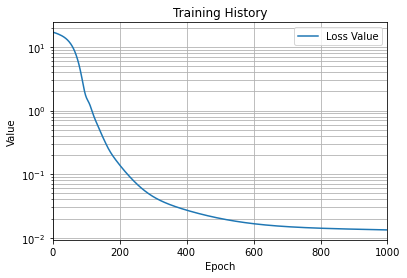

In [7]:
fig, ax = plt.subplots(1,1)

epoch_vec = np.arange(len(loss_h))
ax.plot(epoch_vec, loss_h, label="Loss Value")

ax.set_title("Training History")
ax.set_xlabel("Epoch")
ax.set_xlim(left=0,  right=total_epochs)
ax.set_ylabel("Value")
ax.set_yscale('log')
ax.grid(True, which='both')

plt.legend()
plt.show()